In [1]:
%matplotlib inline
from IPython.display import display, HTML
from analysis import Analysis
from models import *
analysis = Analysis('weather', logger=display)
analysis.load_data()

//anaconda/envs/python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now setting the features and predictor to just be the avg temperature value.

In [2]:
predictor = 'actual_mean_temp'
features = [predictor]
analysis.set_feature_predictor_columns(features, predictor)
analysis.train_test_split()

'Number of train data points: 292'

'Number of test data points: 73'

Set some parameters that are used by some of the models

In [3]:
# The number of days to chunk inputs by
NUM_DAYS = 5

# 
NUM_FEATURES = len(analysis.features)

Going to try each different model.

# Raw Data

Raw Data means that the model simply takes the data as a sequence and no data manipulation is performed.

## ARIMA

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1827.791, BIC=1846.175, Fit time=1.269 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1962.638, BIC=1977.345, Fit time=0.316 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1864.170, BIC=1878.877, Fit time=0.602 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1829.085, BIC=1851.146, Fit time=1.297 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1986.101, BIC=2000.808, Fit time=0.380 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=0.264 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1831.275, BIC=1857.012, Fit time=4.408 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1811.604, BIC=1833.664, Fit time=1.360 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1

'Train Error: 5.07415076317  Num NaN: 0'

'Test Error: 6.39170757717    Num NaN: 0'

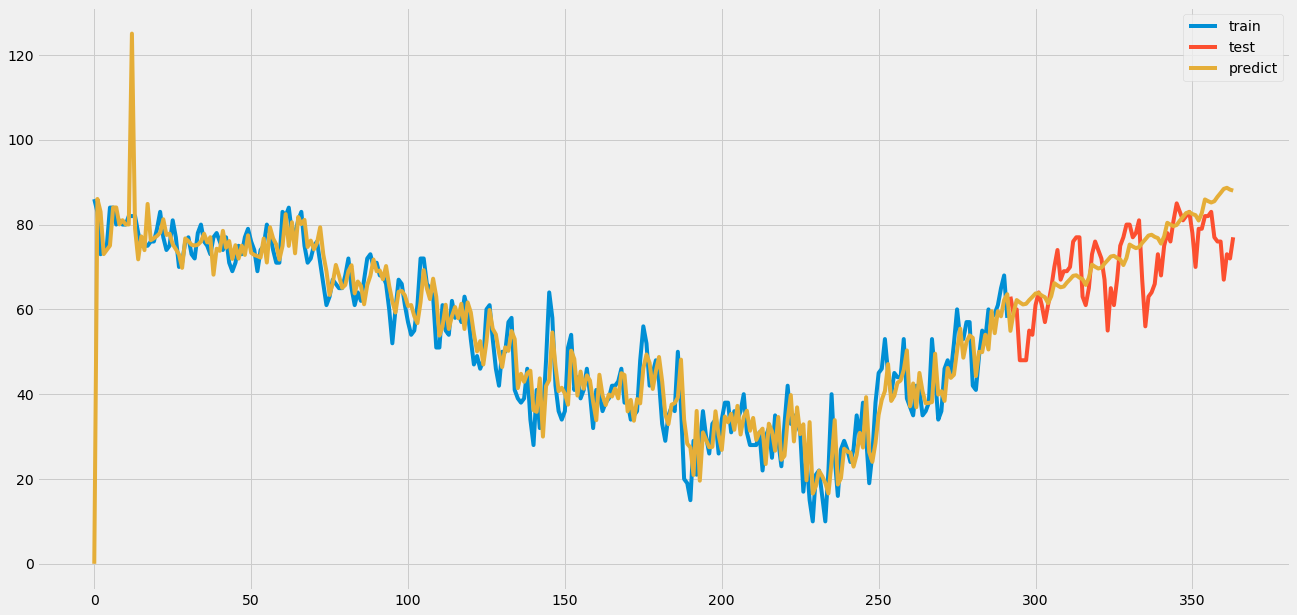

In [4]:
model = ARIMA(analysis, use_features=False)
analysis.run_model(model)

'Train Error: 4.50479452055  Num NaN: 0'

'Test Error: 4.60555555556    Num NaN: 0'

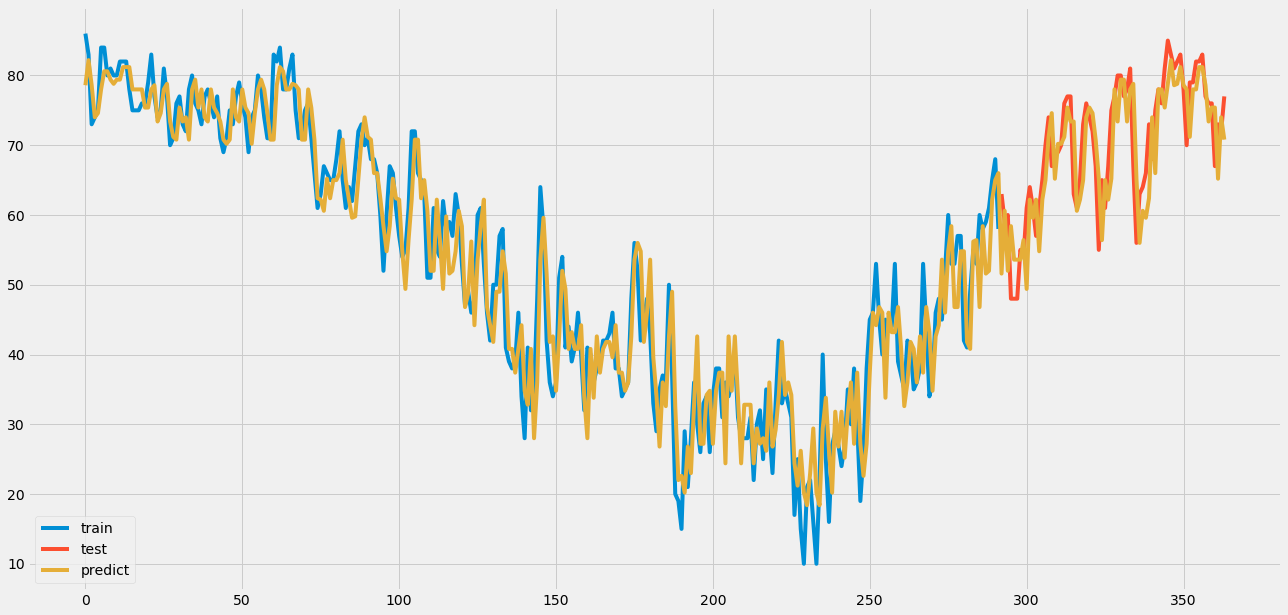

In [5]:
from sklearn.neighbors import KNeighborsRegressor
model = Regressor(analysis, KNeighborsRegressor)
analysis.run_model(model)

//anaconda/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


'Train Error: 2.39882546705e+12  Num NaN: 0'

'Test Error: 3.20569006666e+12    Num NaN: 0'

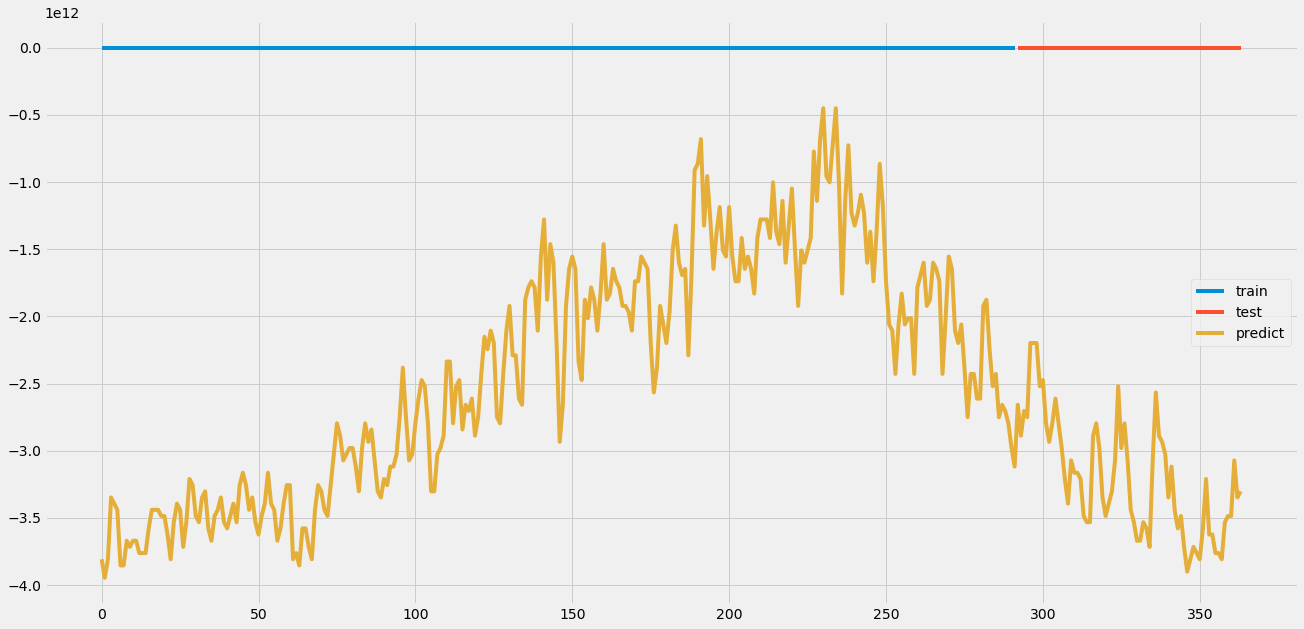

In [6]:
from sklearn.linear_model import SGDRegressor
model = Regressor(analysis, SGDRegressor)
analysis.run_model(model)

'Train Error: 4.33286861303  Num NaN: 0'

'Test Error: 4.26080780716    Num NaN: 0'

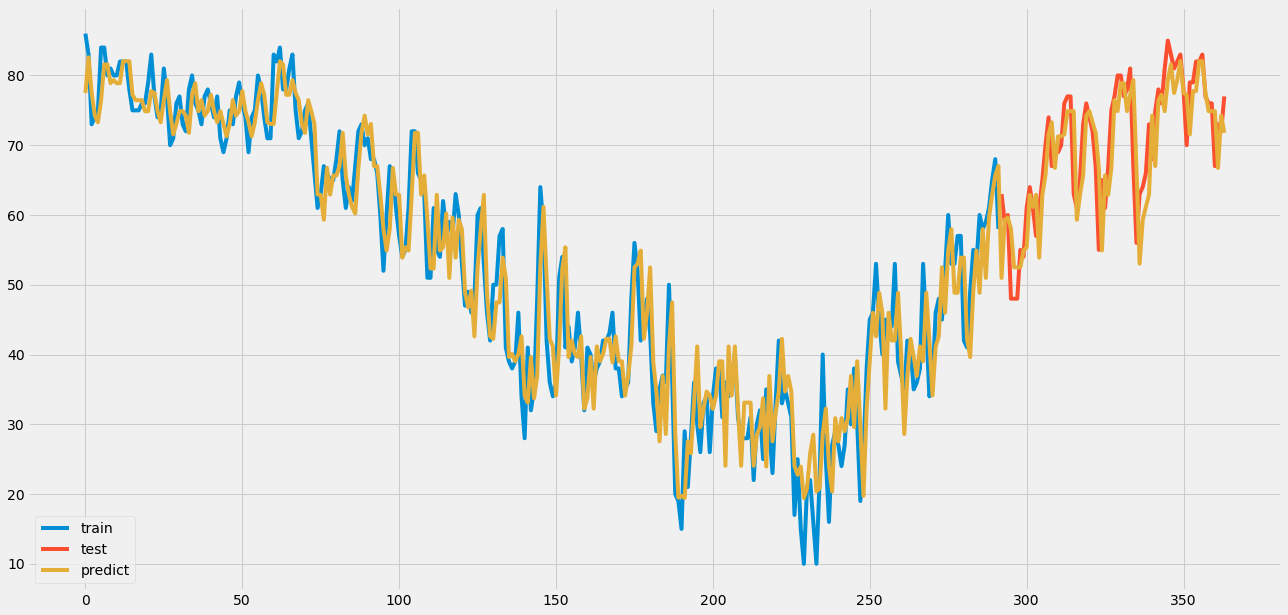

In [7]:
from sklearn.ensemble import RandomForestRegressor
model = Regressor(analysis, RandomForestRegressor)
analysis.run_model(model)

'Train Error: 4.627709868  Num NaN: 0'

'Test Error: 4.64428785749    Num NaN: 0'

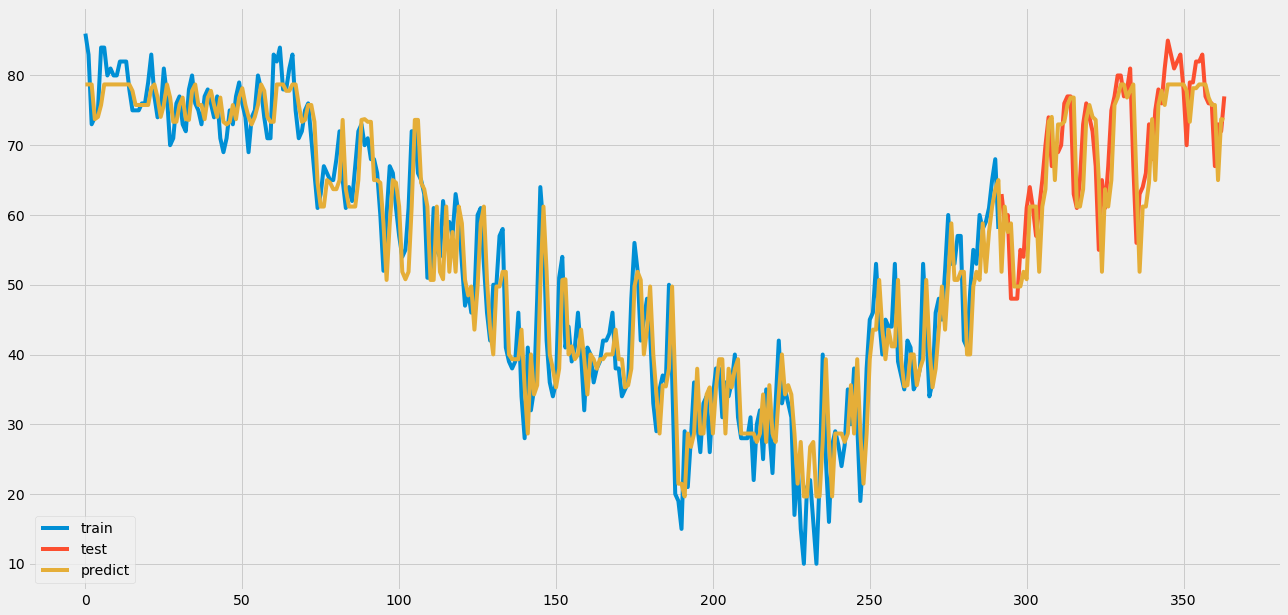

In [8]:
from sklearn.ensemble import AdaBoostRegressor
model = Regressor(analysis, AdaBoostRegressor)
analysis.run_model(model)

'Train Error: 4.26186708473  Num NaN: 0'

'Test Error: 4.49174209436    Num NaN: 0'

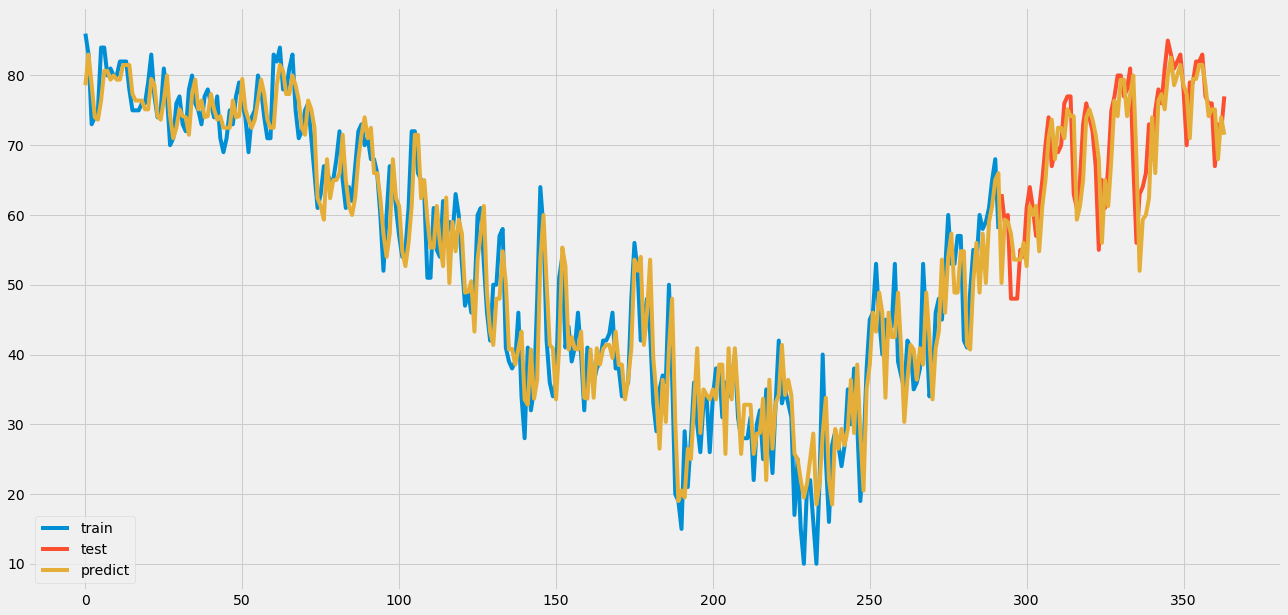

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
model = Regressor(analysis, GaussianProcessRegressor)
analysis.run_model(model)

# Chunking Data

Now going to use models that require chunking.  We perform chunking by taking the time series:

x = (x0, x1, x2, x3, ...)
y = (x1, x2, x3, x4, ...)

and modifying it such that if the chunk parameter, c, is set to 3:

x = ((x0, x1, x2), (x1, x2, x3), (x2, x3, x4), ...)
y = (x3, x4, x5, ...)

This results in the first c values in not having a prediction and thus (Num NaN is > 0 and == c).



## LinearRegression

'Train Error: 5.70952644694  Num NaN: 5'

'Test Error: 6.19872245938    Num NaN: 5'

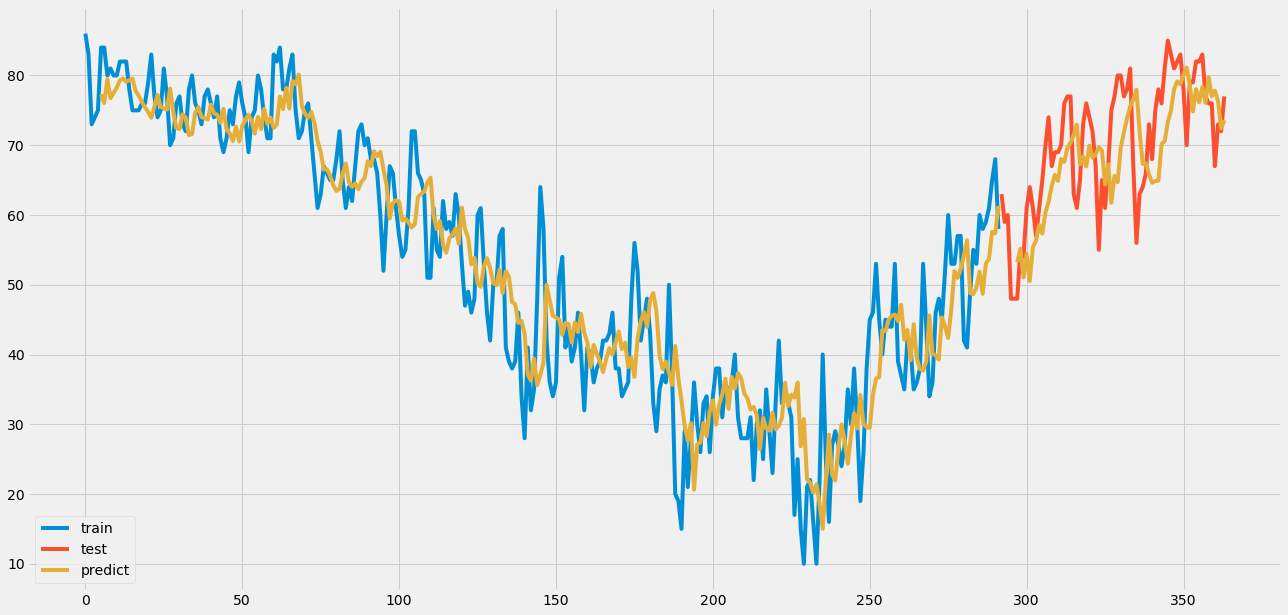

In [10]:
model = LinearRegression(analysis, num_days=NUM_DAYS)
analysis.run_model(model)

## FeedForward Neural Network

Using TensorFlow backend.


Train on 287 samples, validate on 67 samples
Epoch 1/10
 - 0s - loss: 0.2625 - val_loss: 0.3886
Epoch 2/10
 - 0s - loss: 0.2093 - val_loss: 0.1497
Epoch 3/10
 - 0s - loss: 0.2038 - val_loss: 0.1409
Epoch 4/10
 - 0s - loss: 0.1956 - val_loss: 0.1609
Epoch 5/10
 - 0s - loss: 0.1981 - val_loss: 0.3052
Epoch 6/10
 - 0s - loss: 0.1988 - val_loss: 0.1551
Epoch 7/10
 - 0s - loss: 0.1946 - val_loss: 0.1442
Epoch 8/10
 - 0s - loss: 0.1913 - val_loss: 0.1584
Epoch 9/10
 - 0s - loss: 0.1994 - val_loss: 0.1634
Epoch 10/10
 - 0s - loss: 0.1870 - val_loss: 0.2147


'Train Error: 14.4923892337  Num NaN: 5'

'Test Error: 16.1061955352    Num NaN: 5'

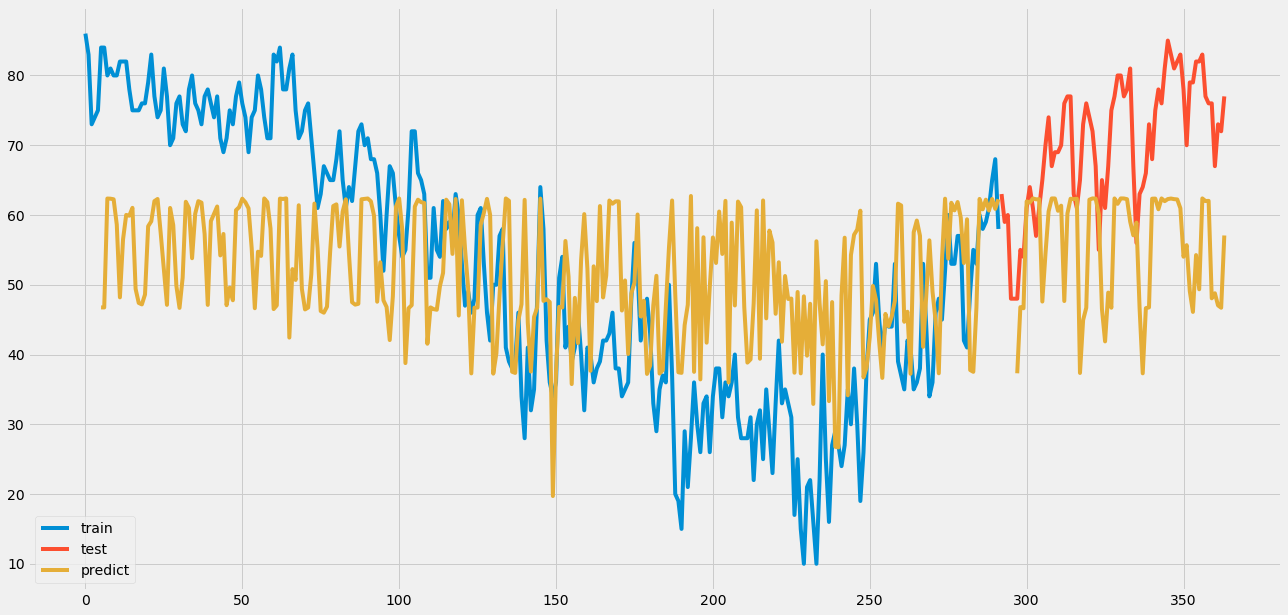

In [11]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

nn = Sequential()
nn.add(layers.Dense(25, activation='tanh',
                    batch_input_shape=(None, NUM_DAYS * NUM_FEATURES)))
nn.add(layers.Dense(10, activation='tanh'))
nn.add(layers.Dense(1, activation='tanh'))
nn.compile(loss='mae', optimizer='sgd')

model = FNN(analysis, nn, num_days=NUM_DAYS)
analysis.run_model(model)


## Recurrent Neural Network with Single Output

Single output means that the chunked timesteps are input and then the final output of the RNN is used as the prediction.

Train on 287 samples, validate on 67 samples
Epoch 1/10
 - 0s - loss: 0.2540 - val_loss: 0.2117
Epoch 2/10
 - 0s - loss: 0.2336 - val_loss: 0.2702
Epoch 3/10
 - 0s - loss: 0.2433 - val_loss: 0.3750
Epoch 4/10
 - 0s - loss: 0.2345 - val_loss: 0.2367
Epoch 5/10
 - 0s - loss: 0.2423 - val_loss: 0.2660
Epoch 6/10
 - 0s - loss: 0.2416 - val_loss: 0.1034
Epoch 7/10
 - 0s - loss: 0.2382 - val_loss: 0.2373
Epoch 8/10
 - 0s - loss: 0.2469 - val_loss: 0.4621
Epoch 9/10
 - 0s - loss: 0.2448 - val_loss: 0.1925
Epoch 10/10
 - 0s - loss: 0.2333 - val_loss: 0.1944


'Train Error: 16.9820712684  Num NaN: 5'

'Test Error: 14.5793496886    Num NaN: 5'

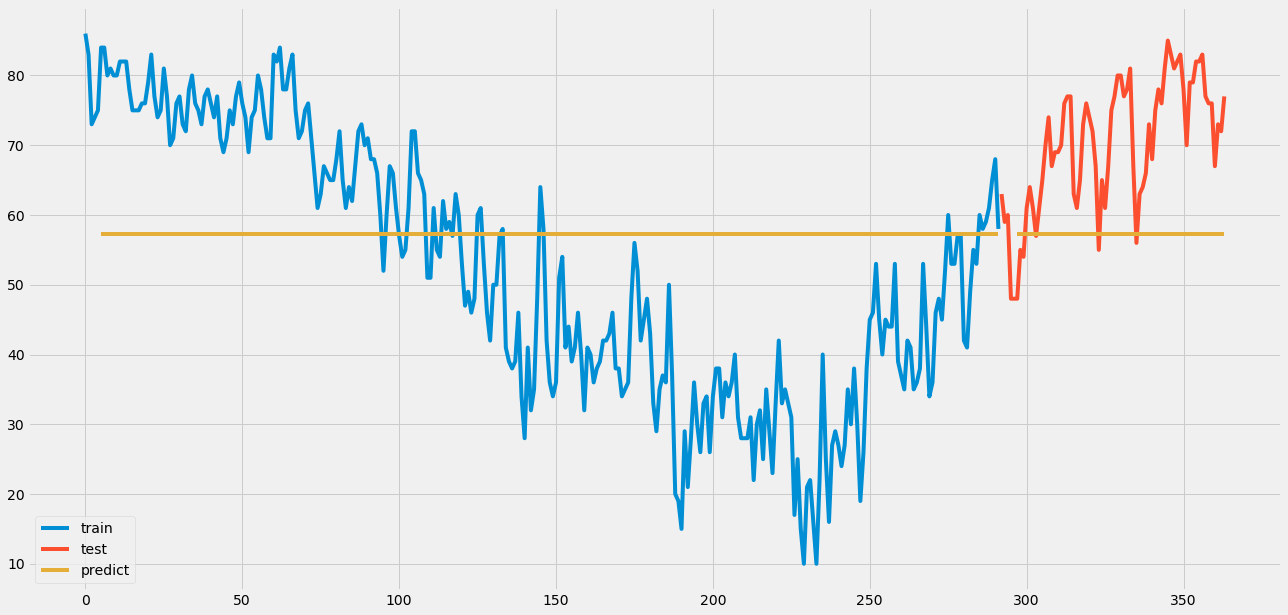

In [12]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

mask_value = -9999

nn = Sequential()
nn.add(layers.Masking(mask_value=mask_value, input_shape=(NUM_DAYS, NUM_FEATURES)))
nn.add(layers.SimpleRNN(50, input_shape=(NUM_DAYS, NUM_FEATURES)))

nn.add(layers.Dense(1, activation='tanh'))
nn.add(layers.Dense(1, activation='linear'))
nn.compile(loss='mae', optimizer=optimizers.RMSprop(lr=0.1))
        
model = RNNSingle(analysis, nn, num_days=NUM_DAYS, mask_value=mask_value)
analysis.run_model(model)

## Recurrent Neural Network with Multiple Outputs

Multiple outputs means that the chunked data is input and the output at each timestep is used.

Train on 59 samples, validate on 15 samples
Epoch 1/10
 - 1s - loss: 0.1491 - val_loss: 0.0733
Epoch 2/10
 - 0s - loss: 0.0579 - val_loss: 0.0420
Epoch 3/10
 - 0s - loss: 0.0315 - val_loss: 0.0240
Epoch 4/10
 - 0s - loss: 0.0167 - val_loss: 0.0130
Epoch 5/10
 - 0s - loss: 0.0098 - val_loss: 0.0088
Epoch 6/10
 - 0s - loss: 0.0066 - val_loss: 0.0062
Epoch 7/10
 - 0s - loss: 0.0049 - val_loss: 0.0044
Epoch 8/10
 - 0s - loss: 0.0040 - val_loss: 0.0033
Epoch 9/10
 - 0s - loss: 0.0034 - val_loss: 0.0025
Epoch 10/10
 - 0s - loss: 0.0030 - val_loss: 0.0020


'Train Error: 27.9357347399  Num NaN: 0'

'Test Error: 19.8802676102    Num NaN: 0'

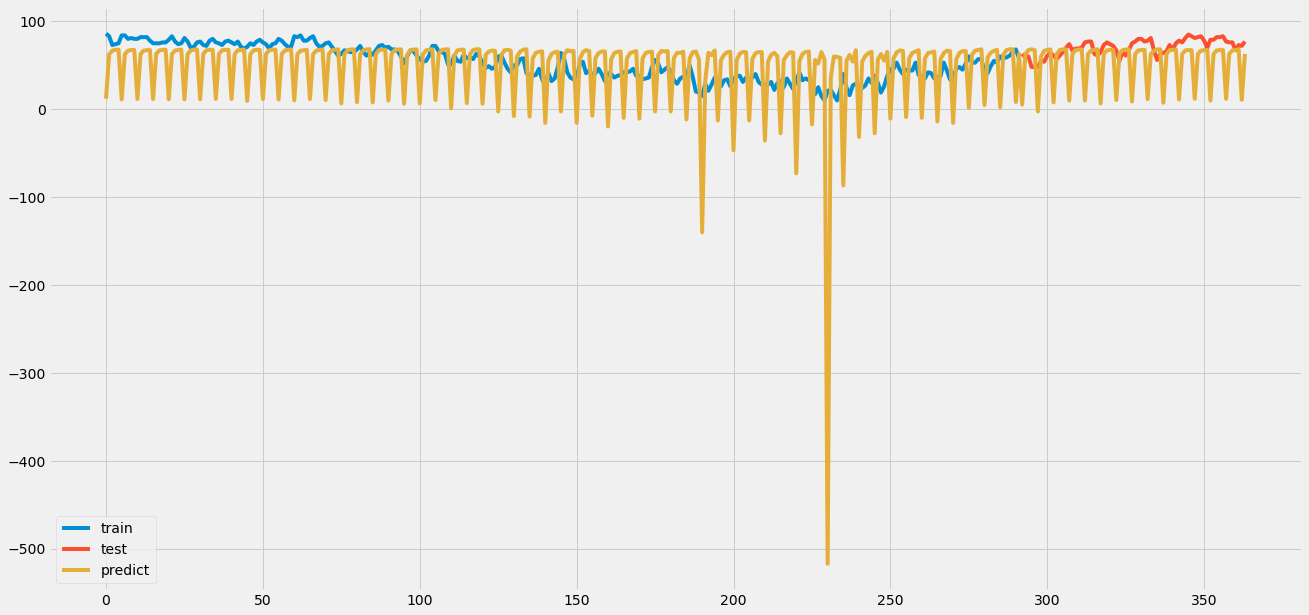

In [13]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

mask_value = -9999

nn = Sequential()
nn.add(layers.Masking(mask_value=mask_value, input_shape=(NUM_DAYS, NUM_FEATURES)))
nn.add(layers.LSTM(50, activation='tanh', input_shape=(NUM_DAYS, NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mae', optimizer='rmsprop')

model = RNNMultiple(analysis, nn, num_days=NUM_DAYS, mask_value=mask_value)
analysis.run_model(model)

## Recurrent Neural Network Complete Sequence

Complete sequence means that the entire sequence is input into the network and each timestep produces an output.  There are no batches, just one long sequence.

//anaconda/envs/python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 1 samples, validate on 1 samples
Epoch 1/10
 - 1s - loss: 0.1486 - val_loss: 0.0986
Epoch 2/10
 - 1s - loss: 0.0691 - val_loss: 0.0705
Epoch 3/10
 - 1s - loss: 0.0462 - val_loss: 0.0549
Epoch 4/10
 - 1s - loss: 0.0341 - val_loss: 0.0449
Epoch 5/10
 - 1s - loss: 0.0265 - val_loss: 0.0376
Epoch 6/10
 - 1s - loss: 0.0213 - val_loss: 0.0320
Epoch 7/10
 - 1s - loss: 0.0174 - val_loss: 0.0277
Epoch 8/10
 - 1s - loss: 0.0146 - val_loss: 0.0244
Epoch 9/10
 - 1s - loss: 0.0126 - val_loss: 0.0215
Epoch 10/10
 - 1s - loss: 0.0110 - val_loss: 0.0181


'Train Error: 97.4893201583  Num NaN: 0'

'Test Error: 182.992258761    Num NaN: 0'

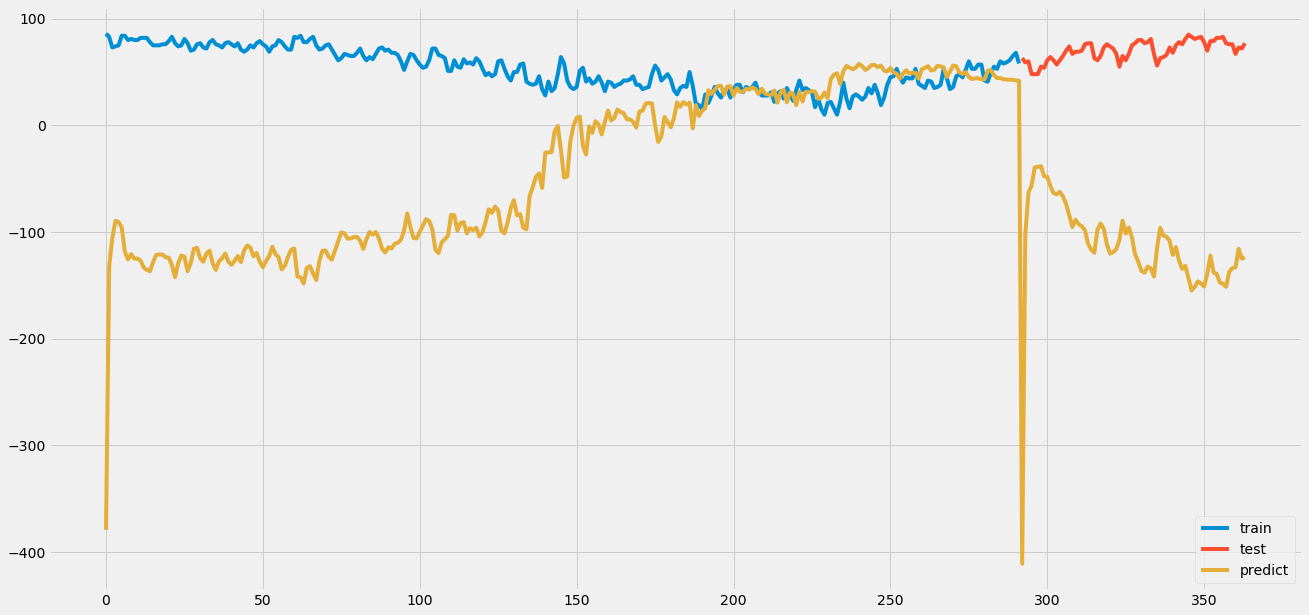

In [14]:
from keras.models import Sequential
from keras import optimizers
from keras import layers

mask_value = -9999

nn = Sequential()
nn.add(layers.Masking(mask_value=mask_value, input_shape=(len(analysis.x_train), NUM_FEATURES)))
nn.add(layers.LSTM(50, activation='tanh', input_shape=(len(analysis.x_train), NUM_FEATURES), return_sequences=True))

nn.add(layers.TimeDistributed(layers.Dense(10, activation='relu')))
nn.add(layers.TimeDistributed(layers.Dense(1, activation='tanh')))
# nn.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))
nn.compile(loss='mae', optimizer='rmsprop')

model = RNNAll(analysis, nn, mask_value=mask_value)
analysis.run_model(model)